# 1. Preparaing the notebook
### Importing packages and libraries

In [1]:
# packages for data manipulation
import pandas as pd
import numpy as np

# packages for data preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

### Reading file and tidying up columns

In [2]:
data = pd.read_csv("./Data/BankChurners.csv")

In [3]:
# dropping irrelevant columns
data = data.drop(columns=["CLIENTNUM", "Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1", "Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2"], axis=1)
data.head(1)

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061


In [4]:
# tidy up and standardise column naming convention
tidied_cols = []
for col_name in data.columns:
    col_name = col_name.lower()
    if '_ct' in col_name:
        col_name = col_name.replace('_ct', '_count')
    if '_chng' in col_name:
        col_name = col_name.replace('_chng', '_change')
    tidied_cols.append( col_name )

data.columns = tidied_cols.copy()
data.columns

Index(['attrition_flag', 'customer_age', 'gender', 'dependent_count',
       'education_level', 'marital_status', 'income_category', 'card_category',
       'months_on_book', 'total_relationship_count', 'months_inactive_12_mon',
       'contacts_count_12_mon', 'credit_limit', 'total_revolving_bal',
       'avg_open_to_buy', 'total_amt_change_q4_q1', 'total_trans_amt',
       'total_trans_count', 'total_count_change_q4_q1',
       'avg_utilization_ratio'],
      dtype='object')

In [5]:
# retrieve categorical and numerical columns
numerical = list(data.describe().columns)
categorical = [i for i in data.columns if i not in numerical and i != "attrition_flag"]

### Splitting into train test split

In [6]:
y = data[["attrition_flag"]]
x = data.drop("attrition_flag", axis=1)
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_age              10127 non-null  int64  
 1   gender                    10127 non-null  object 
 2   dependent_count           10127 non-null  int64  
 3   education_level           10127 non-null  object 
 4   marital_status            10127 non-null  object 
 5   income_category           10127 non-null  object 
 6   card_category             10127 non-null  object 
 7   months_on_book            10127 non-null  int64  
 8   total_relationship_count  10127 non-null  int64  
 9   months_inactive_12_mon    10127 non-null  int64  
 10  contacts_count_12_mon     10127 non-null  int64  
 11  credit_limit              10127 non-null  float64
 12  total_revolving_bal       10127 non-null  int64  
 13  avg_open_to_buy           10127 non-null  float64
 14  total_

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, stratify = y, random_state = 2021)

# 2. Data Cleaning

### Dropping columns with correlation

In [8]:
x_train = x_train.drop( columns=["customer_age", "avg_open_to_buy", "total_trans_count"] )
x_test = x_test.drop( columns=["customer_age", "avg_open_to_buy", "total_trans_count"] )

### Impute unknown values

In [9]:
def impute_unknown(df_x):
    """
        Imputes unknown values with their mode
    """
    x = df_x.copy()

    marital_status_mode = x["marital_status"].mode()[0]
    x["marital_status"] = x["marital_status"].replace("Unknown", marital_status_mode)
    education_level_mode = x["education_level"].mode()[0]
    x["education_level"] = x["education_level"].replace("Unknown", education_level_mode)
    income_category_mode = x["income_category"].mode()[0]
    x["income_category"] = x["income_category"].replace("Unknown", income_category_mode)
    
    return x

x_train = impute_unknown(x_train)
x_test = impute_unknown(x_test)

# 3. Feature Engineering

In [10]:
def feature_engineering(df_x, df_y):
    x = df_x.copy()
    y = df_y.copy()
    
    # Binary Encoding — features with binary categories  
    attrition_mapper = {"Existing Customer":0, "Attrited Customer":1}
    y["attrition_flag"] = y["attrition_flag"].replace(attrition_mapper)
    
    gender_mapper = {"F":0, "M":1}
    x["gender"] = x["gender"].replace(gender_mapper)
    
    # One Hot Encoding — features with nominal categories
    onehot_enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
    values = onehot_enc.fit_transform(x[["marital_status"]])
    labels = np.array(["divorced", "married", "single"]).ravel()
    marital_status_df = pd.DataFrame(values, columns=labels)

    x.reset_index(drop=True, inplace=True)
    marital_status_df.reset_index(drop=True, inplace=True)
    x = pd.concat([x, marital_status_df], axis=1)
    x.drop("marital_status", axis=1, inplace=True)
    
    # Ordinal Encoding — features with ordinal categories
    edu_level_mapper = {"Doctorate":1, "Post-Graduate":2, "Graduate":3, "College":4, "High School":5, "Uneducated":6}
    x["education_level"] = x["education_level"].replace(edu_level_mapper)

    income_cat_mapper = {"$120K +":1, "$80K - $120K":2, "$60K - $80K":3, "$40K - $60K":4, "Less than $40K":5}
    x["income_category"] = x["income_category"].replace(income_cat_mapper)

    card_cat_mapper = {"Platinum":1, "Gold":2, "Silver":3, "Blue":4}
    x["card_category"] = x["card_category"].replace(card_cat_mapper)
    
    return x, y

x_train, y_train = feature_engineering(x_train, y_train)
x_test, y_test = feature_engineering(x_test, y_test)

# 4. Feature Selection

## 4.1 Decision Tree
---

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import matplotlib.pyplot as plt

In [12]:
x_train.columns

Index(['gender', 'dependent_count', 'education_level', 'income_category',
       'card_category', 'months_on_book', 'total_relationship_count',
       'months_inactive_12_mon', 'contacts_count_12_mon', 'credit_limit',
       'total_revolving_bal', 'total_amt_change_q4_q1', 'total_trans_amt',
       'total_count_change_q4_q1', 'avg_utilization_ratio', 'divorced',
       'married', 'single'],
      dtype='object')

[Text(465.0, 755.0, 'gender <= 0.5\ngini = 0.27\nsamples = 8101\nvalue = [6799, 1302]\nclass = Existing Customer'),
 Text(232.5, 453.0, 'education_level <= 1.5\ngini = 0.288\nsamples = 4239\nvalue = [3499, 740]\nclass = Existing Customer'),
 Text(116.25, 151.0, 'gini = 0.39\nsamples = 211\nvalue = [155, 56]\nclass = Existing Customer'),
 Text(348.75, 151.0, 'gini = 0.282\nsamples = 4028\nvalue = [3344, 684]\nclass = Existing Customer'),
 Text(697.5, 453.0, 'income_category <= 1.5\ngini = 0.249\nsamples = 3862\nvalue = [3300, 562]\nclass = Existing Customer'),
 Text(581.25, 151.0, 'gini = 0.3\nsamples = 560\nvalue = [457, 103]\nclass = Existing Customer'),
 Text(813.75, 151.0, 'gini = 0.239\nsamples = 3302\nvalue = [2843, 459]\nclass = Existing Customer')]

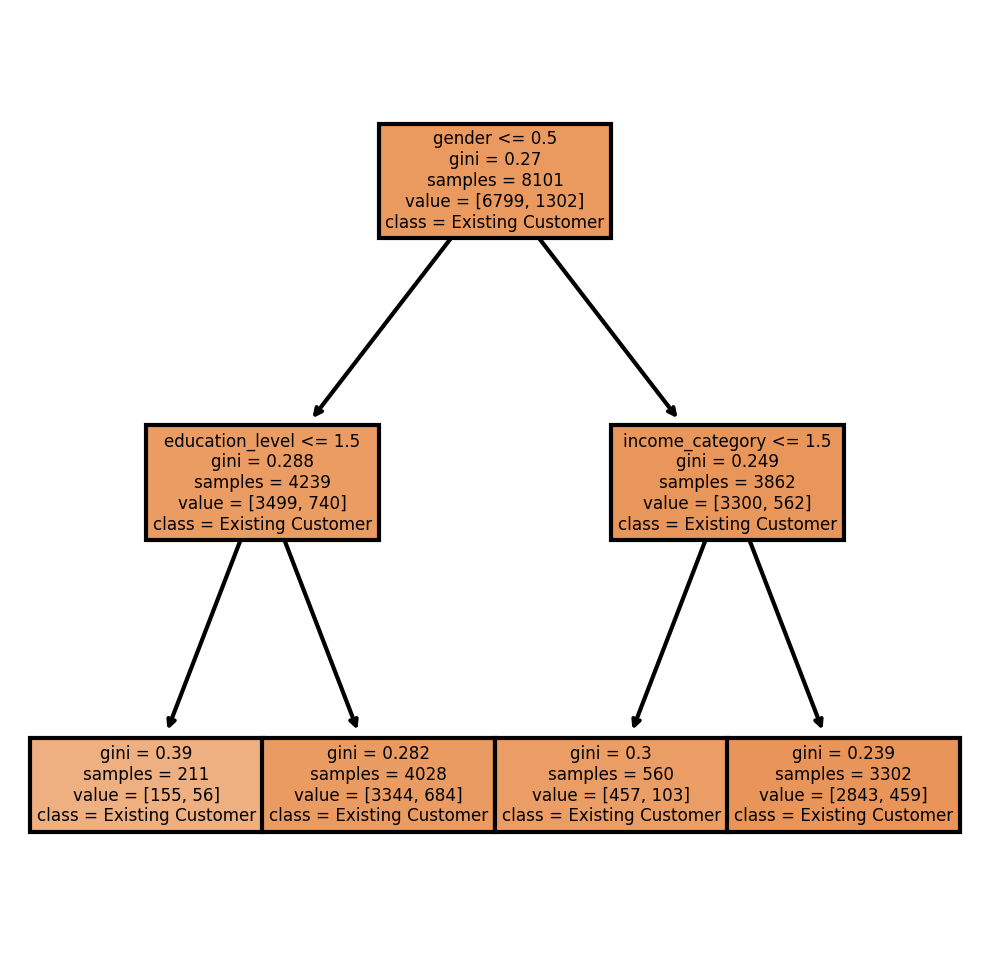

In [15]:
categorical = ['gender', 'education_level',
               'income_category', 'card_category',
               'divorced', 'married', 'single'
              ]

clf = DecisionTreeClassifier(max_depth=2, random_state=2021)
clf.fit(x_train[categorical], y_train)

class_labels = ['Existing Customer', 'Attrited Customer']
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (4,4), dpi=300)
tree.plot_tree(clf,
               feature_names = categorical,
               class_names = class_labels,
               filled = True)

[Text(465.0, 755.0, 'total_count_change_q4_q1 <= 0.504\ngini = 0.27\nsamples = 8101\nvalue = [6799, 1302]\nclass = Existing Customer'),
 Text(232.5, 453.0, 'total_revolving_bal <= 599.5\ngini = 0.5\nsamples = 1263\nvalue = [643, 620]\nclass = Existing Customer'),
 Text(116.25, 151.0, 'gini = 0.328\nsamples = 499\nvalue = [103, 396]\nclass = Attrited Customer'),
 Text(348.75, 151.0, 'gini = 0.414\nsamples = 764\nvalue = [540, 224]\nclass = Existing Customer'),
 Text(697.5, 453.0, 'total_revolving_bal <= 577.5\ngini = 0.18\nsamples = 6838\nvalue = [6156, 682]\nclass = Existing Customer'),
 Text(581.25, 151.0, 'gini = 0.391\nsamples = 1642\nvalue = [1204, 438]\nclass = Existing Customer'),
 Text(813.75, 151.0, 'gini = 0.09\nsamples = 5196\nvalue = [4952, 244]\nclass = Existing Customer')]

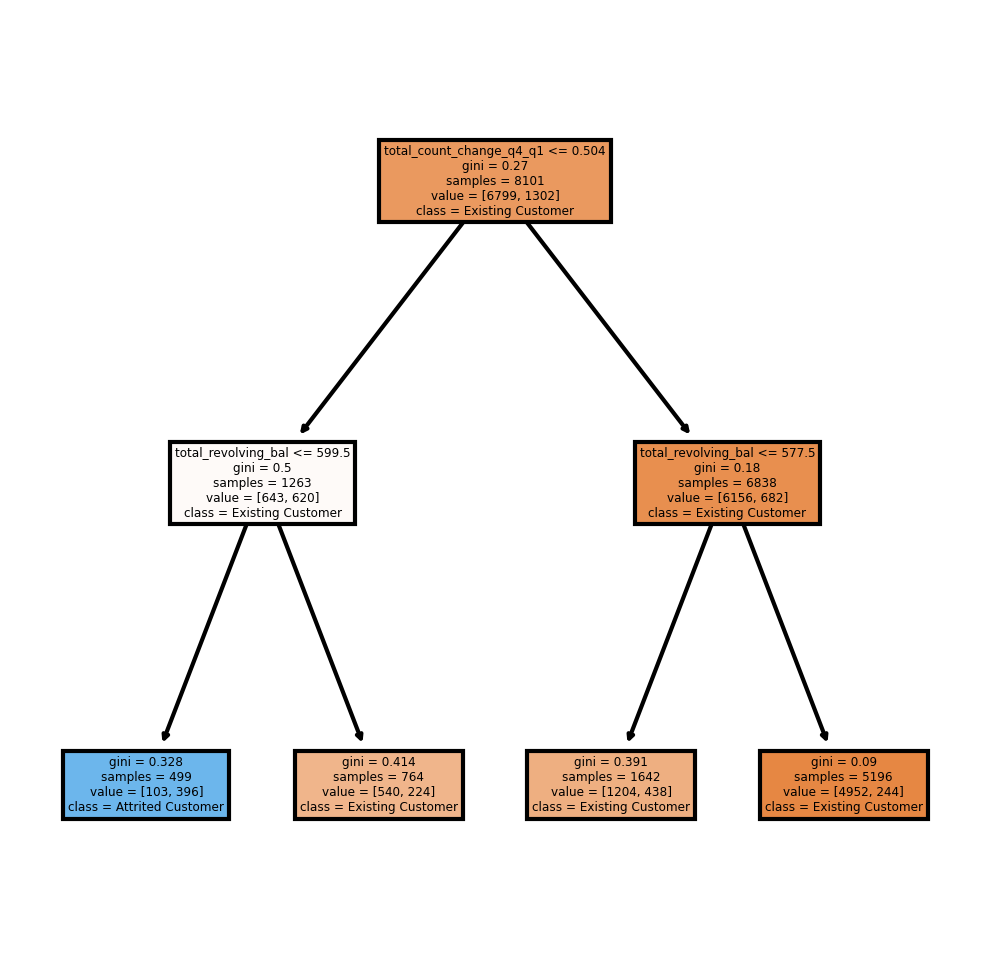

In [13]:
clf = DecisionTreeClassifier(max_depth=2, random_state=2021)
clf.fit(x_train, y_train)

class_labels = ['Existing Customer', 'Attrited Customer']
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (4,4), dpi=300)
tree.plot_tree(clf,
               feature_names = x_train.columns,
               class_names = class_labels,
               filled = True)

## 4.2 RandomForestClassifier
---

## 4.3 Lasso Regression
---

# 5. Feature Transformation and Feature Scaling

In [ ]:
def transformation_scaling(df_x, df_y):
    x = df_x.copy()
    y = df_y.copy()
    
    # Feature Transformation — Log Transformation for skewed data
    skewed = ["credit_limit", "total_amt_change_q4_q1", "total_trans_amt", "total_count_change_q4_q1"]

    for skewed_col in skewed:
        x[skewed_col] = np.log(x[skewed_col].mask(x[skewed_col] <=0)).fillna(0)

    # Feature Scaling - normalise features
    scaler = MinMaxScaler()
    x[numerical] = scaler.fit_transform(x[numerical]) 
    
    return x, y

x_train, y_train = transformation_scaling(x_train, y_train)
x_test, y_test = transformation_scaling(x_test, y_test)

# 4. Exporting preprocessed Train Test sets to csv files

In [ ]:
train = pd.concat([x_train, y_train], axis=1)
test = pd.concat([x_test, y_test], axis=1)
try:
    train.to_csv("./Data/train.csv", index=False)
    test.to_csv("./Data/test.csv", index=False)
    print('Succesfully exported')
except:
    print('Error')